# Wrangle 
Data Acquisition + Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from wrangle import prep_fitbit, split_fitbit, visualize_split

In [2]:
# wrangled data 
df = prep_fitbit()

In [3]:
# drop categorical columns (only useful for visuals)
df.drop(columns=['month', 'weekday'], inplace=True)

In [4]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2.0,1347,93.0,0.0,0.0,566
2018-04-27,3649,9971,4.70,19.0,1158,219.0,46.0,17.0,1752
2018-04-28,3379,3521,1.66,2.0,702,155.0,22.0,11.0,1124
2018-04-29,2851,1639,0.77,0.0,891,122.0,0.0,0.0,602
2018-04-30,2825,1323,0.62,0.0,880,104.0,0.0,0.0,540


In [5]:
# split data into train 50% validate 30% test 20%
train, validate, test = split_fitbit(df)

---
# Modeling
> Forecasting: Predict the next two weeks of activity from 12/07/18 - 12/21/18

In [6]:
from model import evaluate, plot_and_eval, append_eval_df

In [7]:
# Create the empty dataframe for evaluation purposes
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

## Single Value Models
---
### Last Observed Value
The simplest method for forecasting is to predict all future values to be the last observed value.

#### Make Predictions
- use the model to predict on validate data

In [8]:
# store Last Obsevered Value in a dictionary. Keys are target variables
# values are the Last Obsevered Value.
d = {}
for col in train.columns:
    if type(col) == 'int':
        d[col] = train[col][-1:][0]
        print(col)
    else:
        d[col] = round(train[col][-1:][0],2)
        print(col)

calories_burned
steps
distance
floors
minutes_sedentary
minutes_lightly_active
minutes_fairly_active
minutes_very_active
activity_calories


In [9]:
# print dictionary
d

{'calories_burned': 4079,
 'steps': 12259,
 'distance': 5.78,
 'floors': 8.0,
 'minutes_sedentary': 704,
 'minutes_lightly_active': 213.0,
 'minutes_fairly_active': 23.0,
 'minutes_very_active': 56.0,
 'activity_calories': 2158}

In [14]:
# yhat_df is the data frame that contains the predictions on 
# the validate dataset
def make_predictions(d, validate):
    yhat_df = pd.DataFrame(d, 
                       index = validate.index)
    return yhat_df

yhat_df = make_predictions(d, validate)

yhat_df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-08-16,4079,12259,5.78,8.0,704,213.0,23.0,56.0,2158
2018-08-17,4079,12259,5.78,8.0,704,213.0,23.0,56.0,2158


#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 921


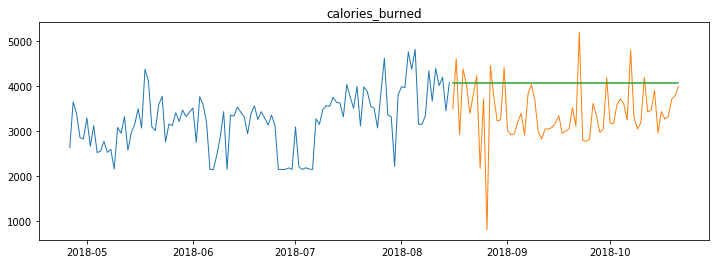

steps -- RMSE: 5156


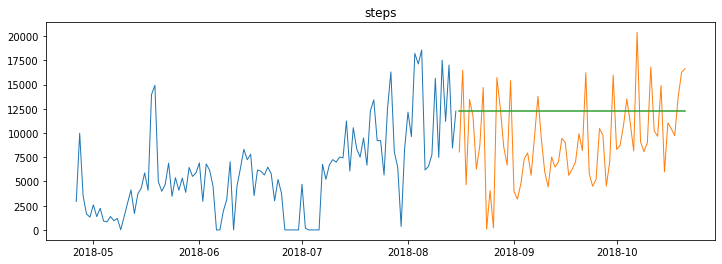

distance -- RMSE: 2


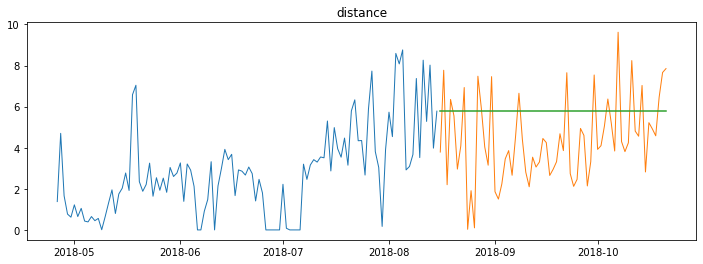

floors -- RMSE: 31


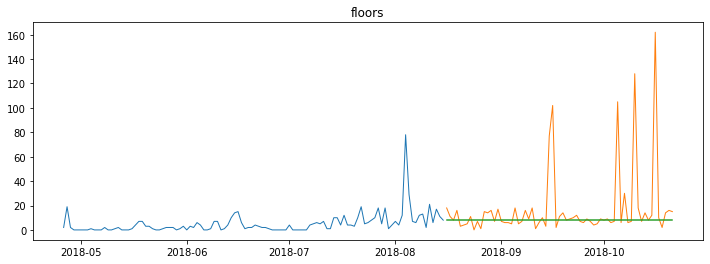

minutes_sedentary -- RMSE: 163


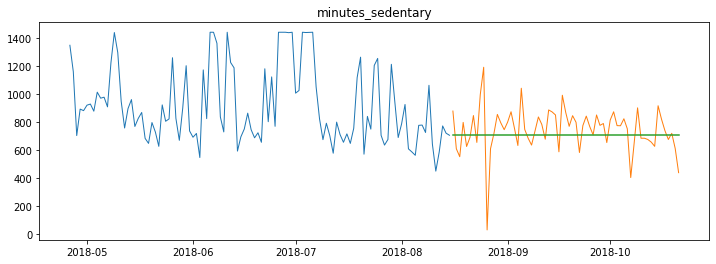

minutes_lightly_active -- RMSE: 64


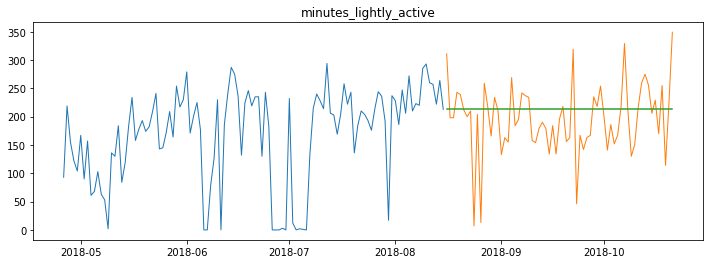

minutes_fairly_active -- RMSE: 18


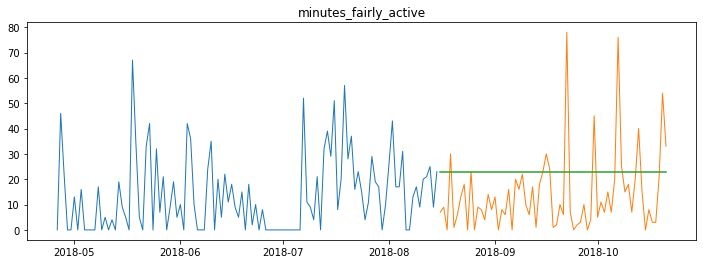

minutes_very_active -- RMSE: 38


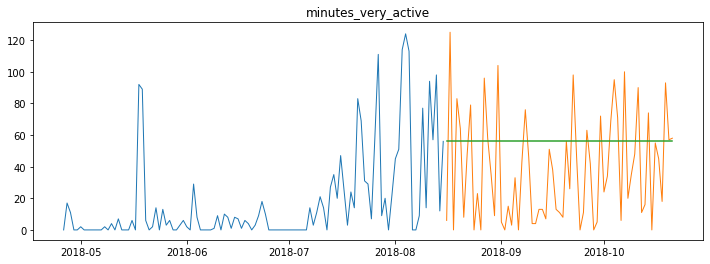

activity_calories -- RMSE: 897


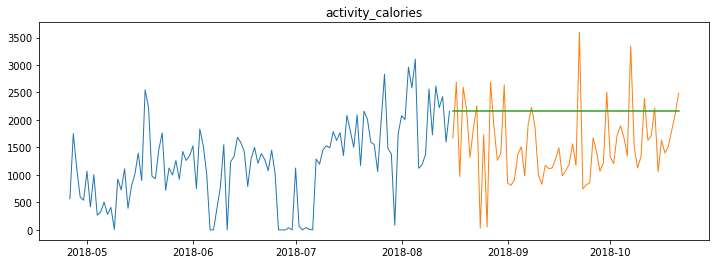

In [11]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [12]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = 'last_observed_value', 
                             target_var = col)

In [13]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0


---
### Simple Average
Take the simple average of historical values and use that value to predict future values.

*This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.*

#### Make Predictions

In [16]:
# store Simple Average in a dictionary. Keys are target variables
# values are the Simple Average.

d = {}
for col in train.columns:
    d[col] = round(train[col].mean(),2)

In [18]:
yhat_df = make_predictions(d, validate)
yhat_df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-17,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98


#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 658


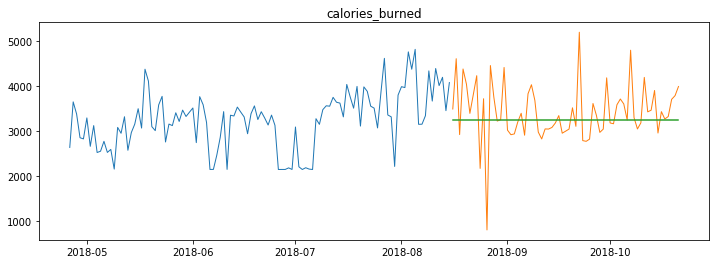

steps -- RMSE: 5356


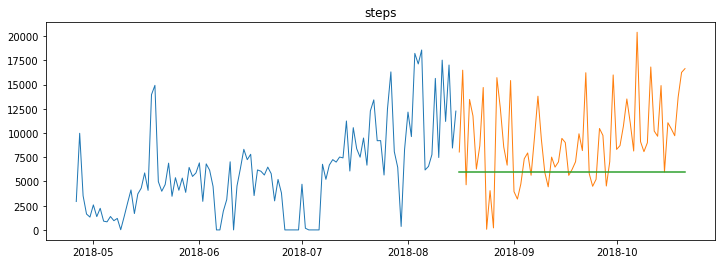

distance -- RMSE: 3


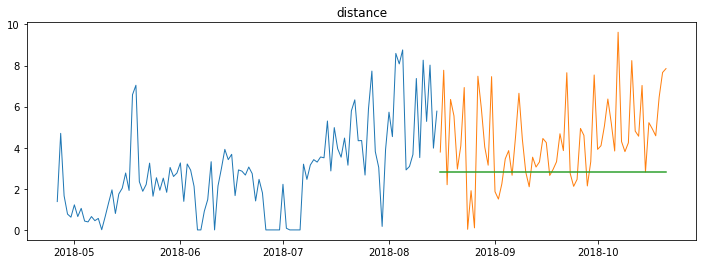

floors -- RMSE: 32


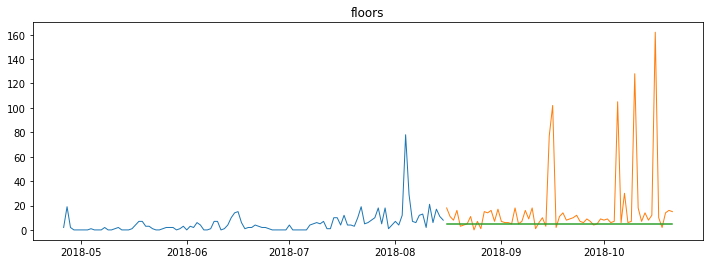

minutes_sedentary -- RMSE: 233


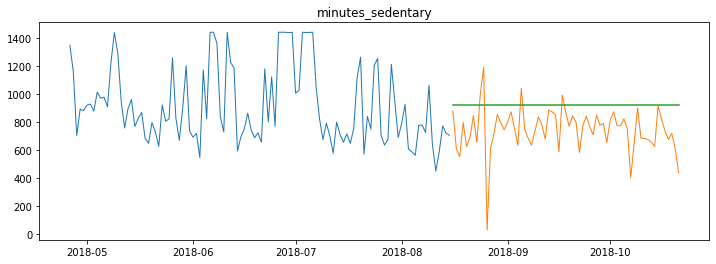

minutes_lightly_active -- RMSE: 68


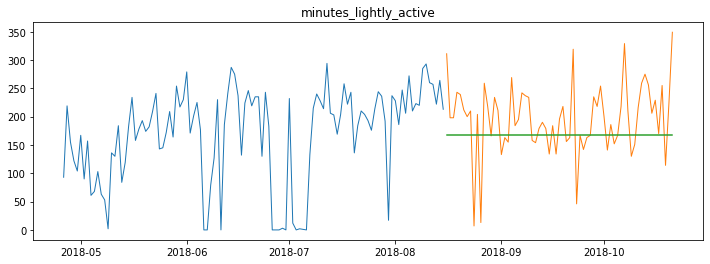

minutes_fairly_active -- RMSE: 16


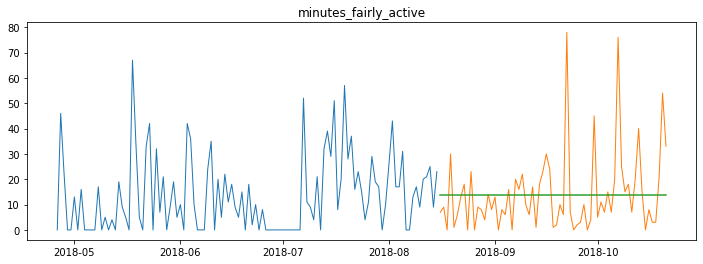

minutes_very_active -- RMSE: 39


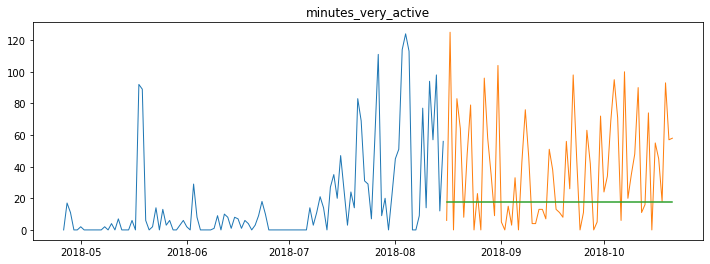

activity_calories -- RMSE: 746


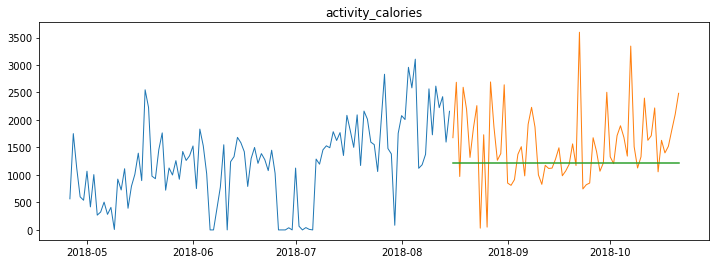

In [19]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [20]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = 'simple_average', 
                             target_var = col)

In [21]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0
9,simple_average,calories_burned,658.0


---
### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

#### Make Predictions

In [22]:
# store 30 day Moving Average 
# compute a 30 day rolling average, in a dictionary. 
# Keys are target variables
# values are the 30 day Moving Average. 

period = 30

d = {}
for col in train.columns:
    d[col] = round(train[col].rolling(period).mean().iloc[-1], 2)

In [23]:
yhat_df = make_predictions(d, validate)
yhat_df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-17,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-18,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93


#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 732


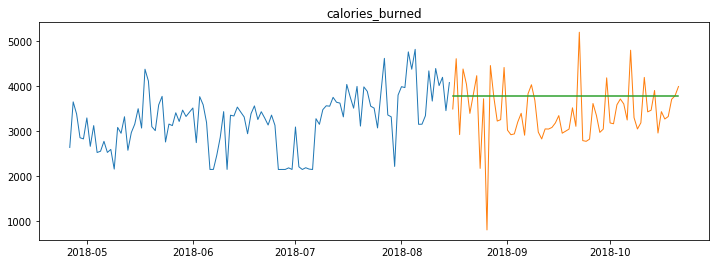

steps -- RMSE: 4425


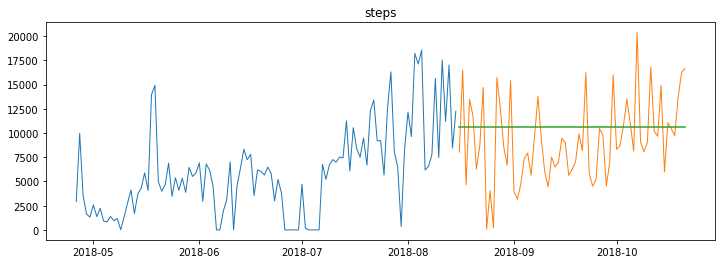

distance -- RMSE: 2


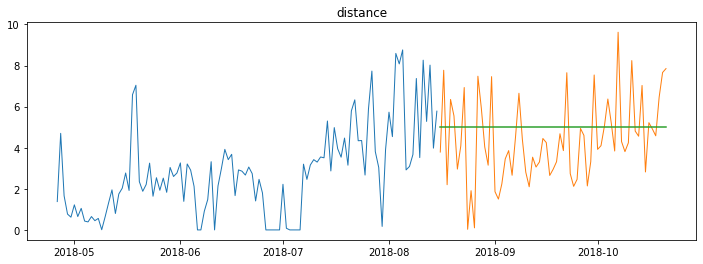

floors -- RMSE: 30


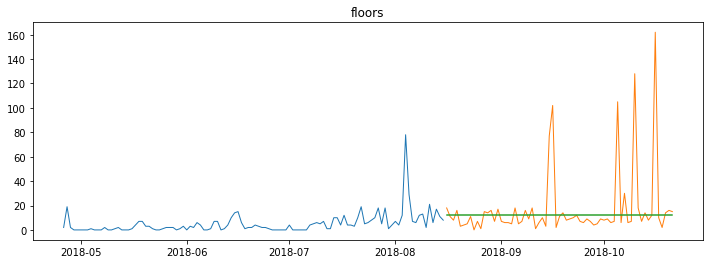

minutes_sedentary -- RMSE: 166


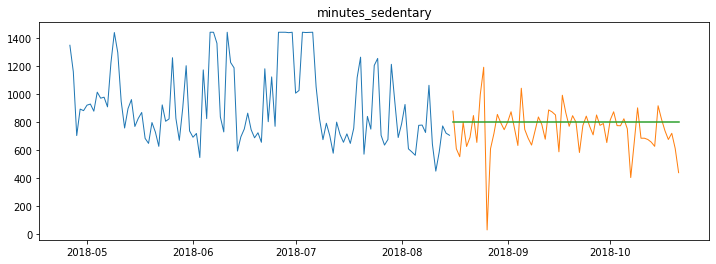

minutes_lightly_active -- RMSE: 66


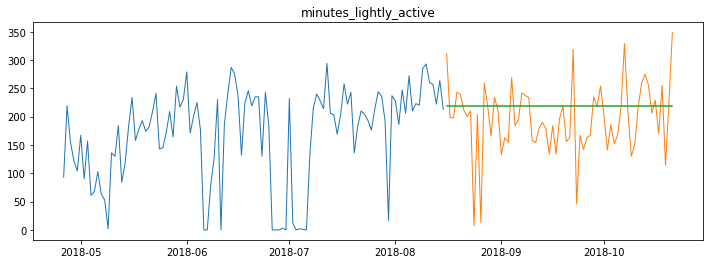

minutes_fairly_active -- RMSE: 16


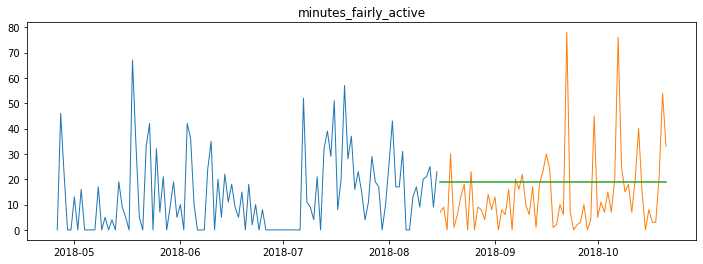

minutes_very_active -- RMSE: 34


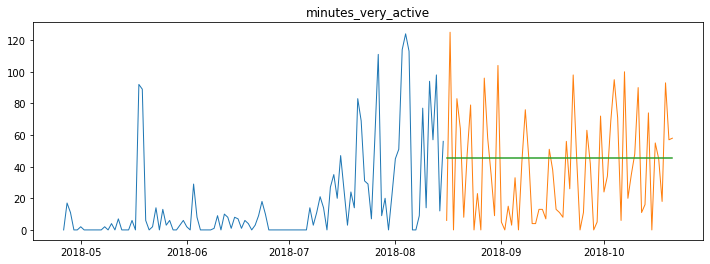

activity_calories -- RMSE: 736


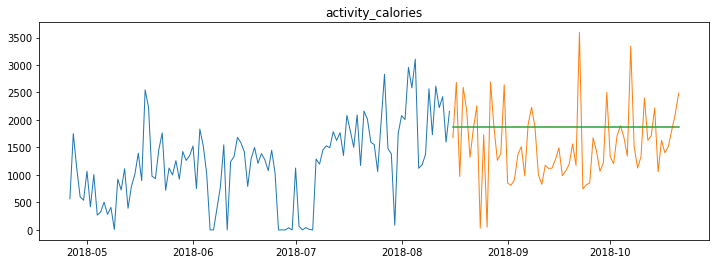

In [24]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [25]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = '30d_moving_avg', 
                             target_var = col)

In [26]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0
9,simple_average,calories_burned,658.0


#### Best so far?

In [49]:
# lowest RMSE for each variable
eval_df.groupby('target_var')['rmse'].min()

target_var
activity_calories          736.0
calories_burned            658.0
distance                     2.0
floors                      30.0
minutes_fairly_active       16.0
minutes_lightly_active      64.0
minutes_sedentary          163.0
minutes_very_active         34.0
steps                     4425.0
Name: rmse, dtype: float64

In [51]:
# filter eval_df where the lowest RMSE from each variable is present
# within the original eval_df up until now
def best_model_feature(eval_df):
    best = eval_df[((eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[0])
              | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[1])
              | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[2])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[3])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[4])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[5])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[6])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[7])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[8]))]
    return best

In [53]:
best = best_model_feature(eval_df)
best

,model_type,target_var,rmse
2,last_observed_value,distance,2.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
9,simple_average,calories_burned,658.0
15,simple_average,minutes_fairly_active,16.0
19,30d_moving_avg,steps,4425.0
20,30d_moving_avg,distance,2.0
21,30d_moving_avg,floors,30.0
24,30d_moving_avg,minutes_fairly_active,16.0
25,30d_moving_avg,minutes_very_active,34.0


Takeaways:
- **Last Observed Value** does best for 
    1. `distance`
    2. `minutes_sedentary`
    3. `minutes_lightly_active`
- **Simple Average** is best for:
    4. `calories_burned`
    5. `minutes_fairly_active`
- **30 Day Moving Avg** is best for:
    6. `steps`
    7. `floors`
    8. `minutes_very_active`
    9. `activity_calories`


## Complex Models
---
### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).

- α / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- β / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

#### Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

calories_burned 



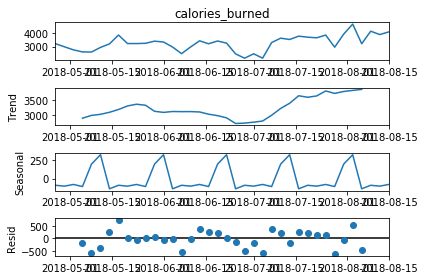

steps 



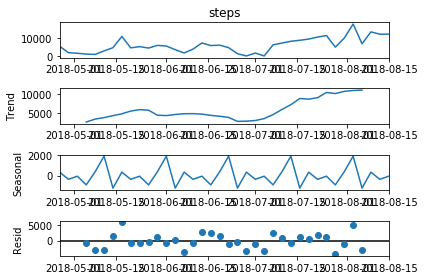

distance 



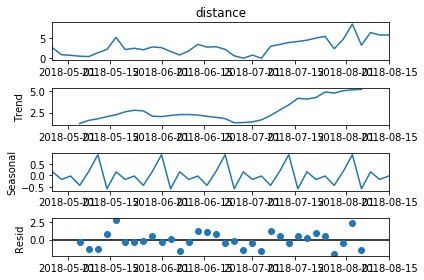

floors 



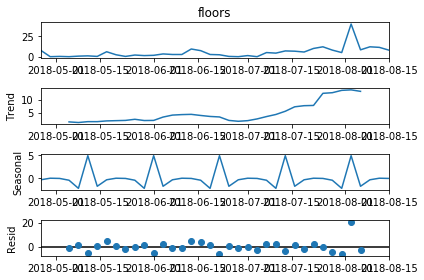

minutes_sedentary 



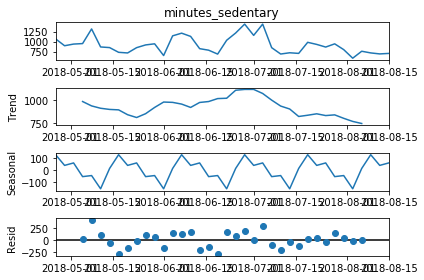

minutes_lightly_active 



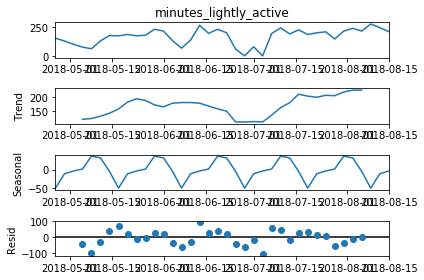

minutes_fairly_active 



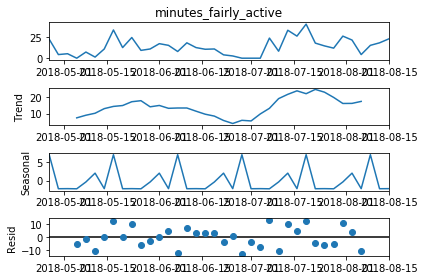

minutes_very_active 



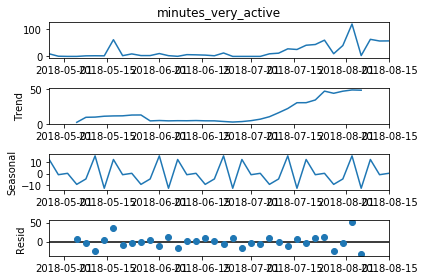

activity_calories 



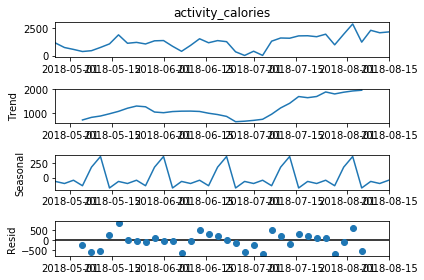

In [56]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3d').mean()).plot()
    plt.show()

#### Make Predictions